# **LRP: Практика**

Ура, друзья! Вы на завершающей практике по градиентным методам курса по [Explainable AI](https://stepik.org/a/198640). В ней разберемся с Layer-wise Relevance Propagation.

В теории быль отмечен факт, что нелинейность преобразований в DNN требует модификации в вычислении, которые мы можем проделать. В частности, правила LRP касаются *сетей глубокого выпрямления (deep rectiﬁer network)* — тех, которые включают в себя слои, $a_k$ вида: $a_k=max(0, \sum_{0,j}a_jw_jk)$.

Вспомним, как выглядит базовая важность нейрона $R_j$, принятая с нейронов следующего слоя:

$$R_j = \sum_k\frac{a_jw_{jk}}{\sum_{0,j}a_jw_{jk}}R_k$$

Что если $a_j$ или $w_j$ равны нулю?

В этой практике вы:
- Изучите применение метода LRP при помощи библиотеки [captum](https://captum.ai/)
- Научитесь применять разные модификации вычисления LRP к определенным слоям сети
- Сравните эффект с применением правил LRP и их отсутствием при помощи одной из метрик качества для карт активации — индекса Джини.

In [ ]:
!pip install captum -q

In [ ]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import requests
import numpy as np
from io import BytesIO

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import LRP
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule

import urllib

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
urllib.request.urlretrieve(url, "imagenet_classes.txt")

with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

Загрузим рабочее изображение и саму модель. В этой практике вернемся к VGG16,
 поскольку архитектура данной модели удобна для практики применения базовых правил LRP, обсужденных в модуле.

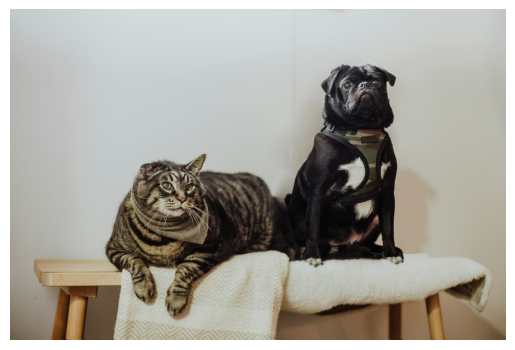

In [ ]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor(),
 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                      std=[0.229, 0.224, 0.225]
 )
])

url = 'https://github.com/SadSabrina/explainable_AI_course/blob/main/HW_module10.1_gradient_methods/cat_and_dog.jpg?raw=true'

image_bytes = requests.get(url).content
image = Image.open(BytesIO(image_bytes))  # Загрузим уже знакомых нам товарищей


plt.figure(figsize=(8,10))
plt.axis('off')
plt.imshow(image);

In [ ]:
resize_transform = transforms.Compose([transforms.Resize((256, 256)),
                                        transforms.CenterCrop(224)])

transformed_image = resize_transform(image)

Преобразуйте изображение и добавьте к нему размерность батча — всё как в прошлых уроках. Чему равна первая размерность при вызове input.shape?

In [ ]:
input = # Ваш код здесь
input = # Ваш код здесь
input.shape

torch.Size([1, 3, 224, 224])

Теперь загрузим модель.

In [ ]:
model = models.vgg16(weights='IMAGENET1K_V1') # Загружаем VGG16
model.eval();

Получите output модели. Какие классы входят в топ-3?

In [ ]:
output = # Ваш код здесь
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = # Ваш код здесь

pred_label_idx.squeeze_().detach().numpy()

predicted_labels = [categories[i] for i in pred_label_idx]
print('Predicted:', predicted_labels, ',\nprobabilities: ', prediction_score.squeeze().detach().numpy(), ')')


Хорошо, в топ-3 наша модель уверенна, что перед нами собака, однако, если вы посмотрите на топ 5 увидите, что класс tabby (кошка) тоже есть в предположениях модели. Перейдем к атрибуциям.

**Вычисление LRP-based атрибуций.**

Сначала применим прямую реализацию LRP, где для каждого слоя используется правило epsilon по умолчанию. В гиперпараметрах метода для нас не будет ничего нового, кроме отсутствия необходимости задавать baseline пример. Он не нужен нам по определению метода.

In [ ]:
model.zero_grad()

lrp = LRP(model)
basic_attributions_lrp = lrp.attribute(input, target=pred_label_idx[0].item())

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Визуализируем атрибуции, используя модуль `viz` из `captum`.

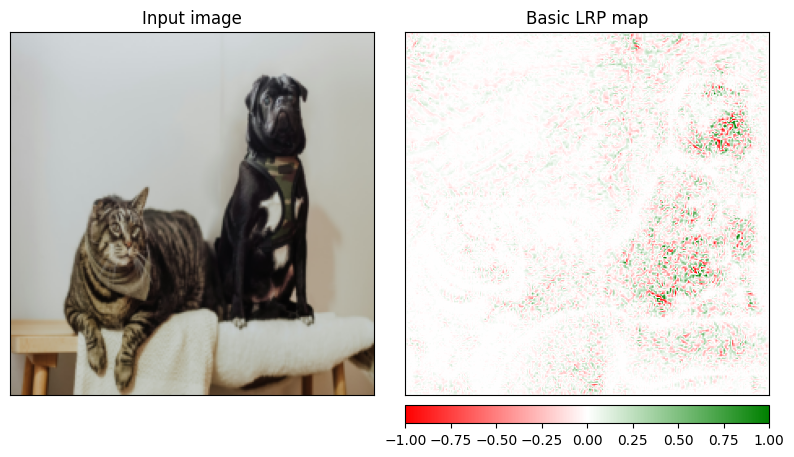

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(basic_attributions_lrp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(transformed_image),
                                      ["original_image", "heat_map"],
                                      ["all", "all"],
                                      show_colorbar=True,
                                      titles=['Input image', 'Basic LRP map'])

Теперь изменим правила распространения для различных слоев. На момент написания курса (2024 год) в Captum реализованы: LRP-Epsilon, LRP-0, LRP-Gamma, LRP-Alpha-Beta и Identity-Rule.

Вернитесь на степик и сопоставьте правила с рекомендациями, согласно теории из модуля.

Теперь применим теорию на практике. Для начала применим какое-нибудь (для определенности возьмём $epsilon$) правило ко всем слоям сети.

Извлеките все слои VGG16 в виде списка. Сколько объектов у вас получилось?

In [ ]:
layers = # Ваш код здесь
num_layers = len(layers)

print(num_layers)

In [ ]:
# epsilon-rule for each layer

for idx_layer in range(1, num_layers):
  setattr(layers[idx_layer], "rule", EpsilonRule(epsilon=0.1))

lrp = LRP(model)
epsilon_attributions_lrp = lrp.attribute(input,
                                target=pred_label_idx[0].item())

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(epsilon_attributions_lrp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(transformed_image),
                                      ["original_image", "heat_map"],
                                      ["all", "all"],
                                      show_colorbar=True,
                                      titles=['Input image', 'Epsilon-rule LRP map'])

Карта стала более разреженной, что для нас отражено в большей информативности карты. Чем меньше важных зон выделено методом аттрибуций, тем точечнее получается наше объяснение.

Теперь скомбинируем несколько правил согласно рекомендациям.

In [ ]:
# Базовое применение комбинации слоев

for idx_layer in range(1, num_layers):
    if idx_layer <= 16:
        setattr(layers[idx_layer], "rule", GammaRule()) # Gamma Rule
    elif 17 <= idx_layer <= 30:
        setattr(layers[idx_layer], "rule", EpsilonRule()) # Epsilon-Rule
    elif idx_layer >= 31:
        setattr(layers[idx_layer], "rule", EpsilonRule(epsilon=0)) # Эквивалентно zero-Rule

lrp = LRP(model)
combined_attributions_lrp = lrp.attribute(input,
                                target=pred_label_idx[0].item())

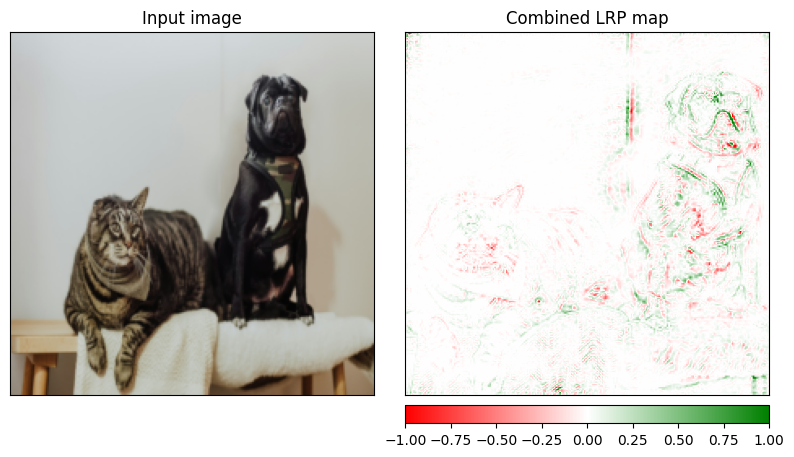

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(combined_attributions_lrp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(transformed_image),
                                      ["original_image", "heat_map"],
                                      ["all", "all"],
                                      show_colorbar=True,
                                      titles=['Input image', 'Combined LRP map'])

На этом шаге призываем вас поэксперементировать! Скомбинируйте правила собственным образом и поделитесь результатами в комментариях к специальному степу!

In [ ]:
# К нижним (первым от входа) слоям сети применено a-b правило

for idx_layer in range(1, num_layers):
  pass


lrp = LRP(model)
custom_attributions_lrp = lrp.attribute(input,
                                target=pred_label_idx[0].item())

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(custom_attributions_lrp.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(transformed_image),
                                      ["original_image", "heat_map"],
                                      ["all", "all"],
                                      show_colorbar=True,
                                      titles=['Input image', 'Custom LRP map'])

**Оценка карт активации.**

Теперь вернемся к оценке карт. До сих пор мы оценивали их субъективно — на предмет "нравится и понятно" или наоборот.

Оценка качества методов объяснения — отдельная область, которой мы коснемся в модуле вскользь. Но хочется, чтобы после курса у вас осталось понимание — методы можно оценивать не только субъективно!

Поэтому рассмотрим одну из мещуствующих метрик — **индекс Джини.**

Как и в других подобластях машинного обучения, неформально он показывает степень разреженности объяснения. Для нас чем более разрежена карта, тем, по предположению она информативнее.

По определению:
$$G(v)=1 - 2*∑_{j}\frac{v_j}{||v||_1}*\frac{d-j+0.5}{d}$$

где  \
$v = [v_1, v_2, v_3, .....,v_d], v_i \leq v_i+1$ — разглаженная карта активации, со значениями, взятыми по модулю и отсортированными в порядке возрастания. \
$$||v||_p = (\sum_jv_j^p)^{\frac{1}{p}}$$

Подробнее про индекс [здесь](https://arxiv.org/pdf/0811.4706v2.pdf).


Реализуем его в коде!

In [ ]:
def get_gini_index(attribution_map):

  flattened_map = attribution_map.flatten().detach().numpy()
  flattened_map_abs_and_sorted = sorted(np.abs(flattened_map)) #Сортируем в порядке возрастания

  d = len(flattened_map_abs_and_sorted) #Длина вектора
  vector_norm = np.linalg.norm(flattened_map_abs_and_sorted, 1)

  s = 0
  for i in range(1, d+1): #Получаем суммы

    coef = (d-i+0.5)/d
    first = flattened_map_abs_and_sorted[i-1]/vector_norm
    s += coef*first


  gini_index = 1-2*s

  return gini_index

Оцените каждую карту индексом Джини. Какая карта наиболее разрежена? (Не считая вашей собственной карты)

In [ ]:
carts = # Ваш код здесь
cart_codes = ['basic', 'epsilon', 'combined']

for card, cart_code in zip(carts, cart_codes):

  print(cart_code + f' card. Gini index = {get_gini_index(card)}')

**На этом всё! Спасибо!** 😊


Примечание: в ноутбуке мы используем модель VGG16, поскольку правила по умолчанию для LRP в настоящее время настроены не для всех моделей. Так, например, для ResNet их может быть проблемно применять и лучше уточнять применимость к архитеткурам в [документации](https://captum.ai/docs/introduction).

**Материал для изучения: пользовательские реализации LRP:**
1. Также реализацию LRP для pyTorch можно найти здесь: https://github.com/fhvilshoj/TorchLRP (попробовать ее самой на практике и написать отзыв)

2. Здесь есть пользовательская реализация [с интерактивностью](https://github.com/kaifishr/PyTorchRelevancePropagation/tree/master)

3. [Здесь](https://git.tu-berlin.de/gmontavon/lrp-tutorial) приведена реализация метода с 0